### Imputing Missing data

Missing data—meaning the absence of values for certain observations—is an unavoidable problem in most data sources


- Removing observations with missing data
- Performing mean or median imputation
- Imputing categorical variables
- Replacing missing values with an arbitrary number
- Finding extreme values for imputation
- Marking imputed values
- Implementing forward and backward fill
- Carrying out interpolation
- Performing multivariate imputation by chained equations
- Estimating missing data with nearest neighbors



### Removing observations with missing data

Complete Case Analysis (CCA), also called list-wise deletion of cases, consists of discarding observations with missing data.

In [531]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Let’s load and display the dataset described in the Technical requirements section:

In [532]:
data = pd.read_csv("../source/ch01-missing-data-imputation/credit_approval_uci.csv")
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,NaN,NaN,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


Let's proceed as we normally would if we were preparing the data to train machine learning models; by splitting the data into a training and a test set:

In [533]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.30, random_state=42)



Let's now make a bar plot with the proportion of missing data per variable in the training and test sets:

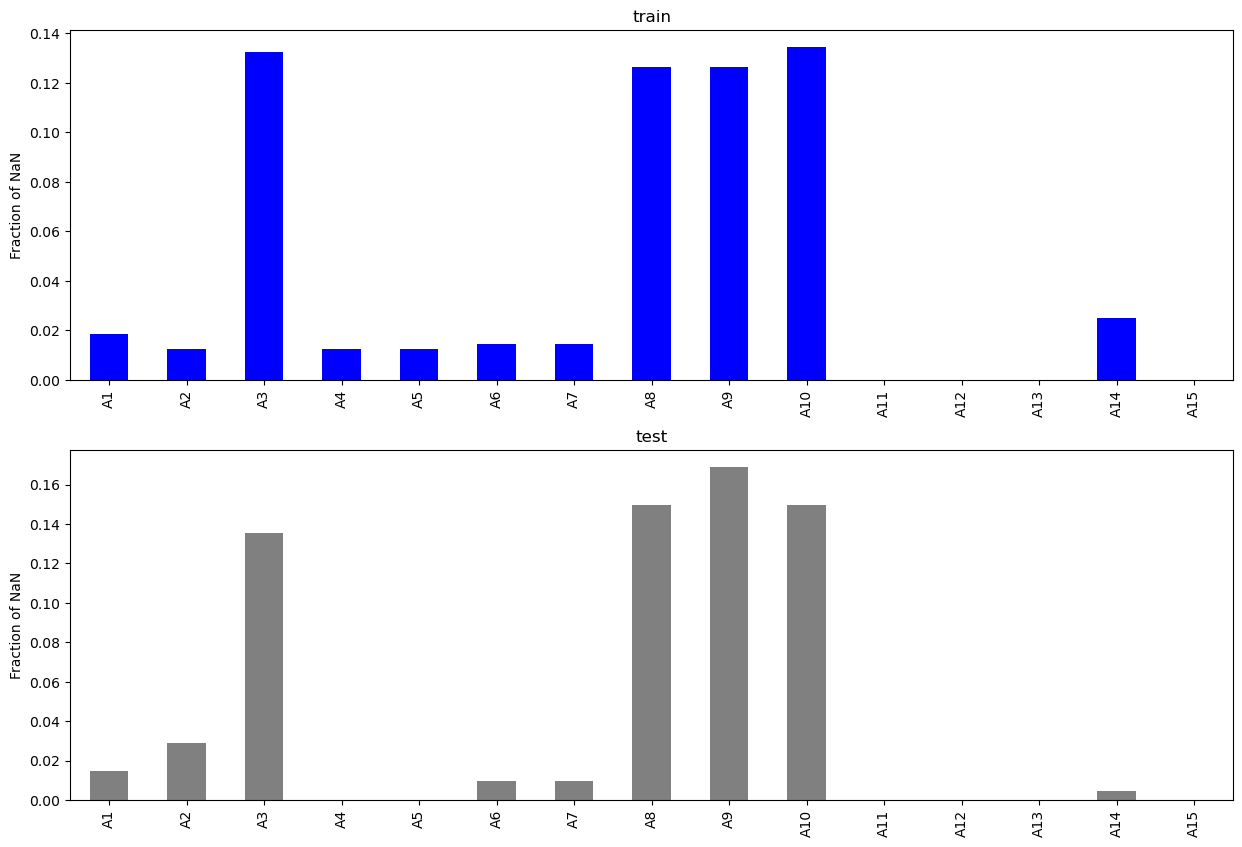

In [534]:
fig, axes = plt.subplots(
    2, 1, figsize=(15, 10), squeeze=False)
X_train.isnull().mean().plot(kind='bar', color='blue', ax=axes[0,0], title='train')
X_test.isnull().mean().plot(kind='bar', color='grey', ax=axes[1, 0], title='test')
axes[0,0].set_ylabel('Fraction of NaN')
axes[1, 0].set_ylabel('Fraction of NaN')
plt.show()

Now, we'll remove observations if they have missing values in any variable:

In [535]:
train_cca = X_train.dropna()
test_cca = X_test.dropna()

Let's print and compare the size of the original and complete case datasets:

In [536]:
print(f"Total observations: {len(X_train)}")
print(f"Observations without: NAN: {len(train_cca)}")

Total observations: 483
Observations without: NAN: 264


After removing observations from the training and test sets, we need to align the target variables:

In [537]:
y_train_cca = y_train.loc[train_cca.index]
y_test_cca = y_test.loc[test_cca.index]

NOTA: Now, the datasets and target variables contain the rows without missing data

### To drop observations with missing data utilizing feature-engine, let's import the required transformer

In [538]:
from feature_engine.imputation import DropMissingData

Let's set up the imputer to automatically find the variables with missing data:

In [539]:
cca = DropMissingData(variables=None, missing_only=True)

In [540]:
cca.fit(X_train)

cca.variables_

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A14']

Let's remove the rows with missing data in the training and test sets:

In [541]:
train_cca = cca.transform(X_train)
test_cca = cca.transform(X_test)

Use train_cca.isnull().sum() to corroborate the absence of missing data in the complete case dataset.

In [542]:
train_cca.isnull().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
dtype: int64

DropMissingData can automatically adjust the target after removing missing data from the training set:

In [543]:
train_c, y_train_c = cca.transform_x_y(X_train, y_train)
test_c, y_test_c = cca.transform_x_y(X_test, y_test)

````
o remove observations with missing data in a subset of variables, use DropMissingData(variables=['A3', 'A4']). To remove rows with nan in at least 5% of the variables, use DropMissingData(threshold=0.95).```

### Performing mean or median imputation

Mean or median imputation consists of replacing missing data with the variable's mean or median value. To avoid data leakage, we determine the mean or median using the train set, and then use these values to impute the train and test sets, and all future data.

Scikit-learn and Feature-engine learn the mean or median from the train set and store these parameters for future use out of the box.

In [544]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import MeanMedianImputer

Let's load the dataset that we prepared in the Technical requirements section:

In [545]:
data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv')

Let's split the data into train and test sets with their respective targets:

In [546]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.3, random_state=0)

Let's make a list with the numerical variables by excluding variables of type object:

In [547]:
numerical_vars = X_train.select_dtypes(exclude='O').columns.to_list()

numerical_vars

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

Let's capture the variables’ median values in a dictionary:

In [548]:
mean_values = X_train[numerical_vars].mean().to_dict()
mean_values

{'A2': 31.8901906779661,
 'A3': 4.841481927710842,
 'A8': 2.354343675417661,
 'A11': 2.5175983436853,
 'A14': 180.5735294117647,
 'A15': 966.2525879917184}

Note how we calculate the median using the train set. We will use these values to replace missing data in the train and test sets. To calculate the mean, use pandas mean() instead of median().

In [549]:
X_train_t = X_train.fillna(value=mean_values)
X_test_t = X_test.fillna(value=mean_values)

In [550]:
X_train_t[numerical_vars].isnull().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64

In [551]:
X_test_t[numerical_vars].isnull().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64

### Now, let's impute missing values with the median using scikit-learn

In [552]:
from sklearn.compose import ColumnTransformer


imputer = SimpleImputer(strategy='median')

ct = ColumnTransformer(
    [("imputer", imputer, numerical_vars)],
    remainder="passthrough",
    force_int_remainder_cols=False,
).set_output(transform='pandas')

NOTE: Scikit-learn can return numpy arrays, pandas DataFrames, or polar frames, depending on how we set out the transform output. By default, it returns numpy arrays.


#### Let's fit the imputer to the train set so that it learns the median values:

In [553]:
ct.fit(X_train)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('imputer', SimpleImputer(strategy='median'),
                                 ['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])])

In [554]:
# Let's check out the learned median values:
ct.named_transformers_.imputer.statistics_

array([ 28.835,   2.75 ,   1.   ,   0.   , 160.   ,   6.   ])

The previous command returns the median values per variable:

#### Let's replace missing values with the median:

In [555]:
X_train_t = ct.transform(X_train)
X_test_t = ct.transform(X_test)

In [556]:
print(numerical_vars)
print(X_train_t.isnull().sum())

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
imputer__A2        0
imputer__A3        0
imputer__A8        0
imputer__A11       0
imputer__A14       0
imputer__A15       0
remainder__A1      4
remainder__A4      4
remainder__A5      4
remainder__A6      4
remainder__A7      4
remainder__A9     69
remainder__A10    66
remainder__A12     0
remainder__A13     0
dtype: int64


### Finally, let's perform median imputation using feature-engine.

In [557]:
imputer = MeanMedianImputer(
    imputation_method='median',
    variables=numerical_vars
)


To perform mean imputation, change imputation_method to "mean". 
By default MeanMedianImputer() will impute all numerical 
variables in the DataFrame, ignoring categorical variables.
Use the variables argument to restrict the imputation to a subset of numerical variables.

In [558]:
imputer.fit(X_train)

imputer.imputer_dict_

{'A2': 28.835, 'A3': 2.75, 'A8': 1.0, 'A11': 0.0, 'A14': 160.0, 'A15': 6.0}

Finally, let's replace the missing values with the median

In [559]:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [560]:
X_train[numerical_vars].isnull().mean()

A2     0.0
A3     0.0
A8     0.0
A11    0.0
A14    0.0
A15    0.0
dtype: float64

## Imputing categorical variables

We typically impute categorical variables with the most frequent category, or with a specific string. To avoid data leakage, we find the frequent categories from the train set. Then, we use these values to impute the train, test, and future datasets. scikit-learn and feature-engine find and store the frequent categories for the imputation, out of the box.

In [561]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import CategoricalImputer

Let's load the dataset that we prepared in the Technical requirements section:

In [562]:
data = pd.read_csv("../source/ch01-missing-data-imputation/credit_approval_uci.csv")

Let's split the data into train and test sets and their respective targets:

In [563]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

Let's capture the categorical variables in a list

In [564]:
categorical_vars = X_train.select_dtypes(include='O').columns.to_list()
categorical_vars

['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

Let's store the variables most frequent categories in a dictionary:

In [565]:
frequent_values = X_train[categorical_vars].mode().iloc[0].to_dict()
frequent_values

{'A1': 'b',
 'A4': 'u',
 'A5': 'g',
 'A6': 'c',
 'A7': 'v',
 'A9': 't',
 'A10': 'f',
 'A12': 'f',
 'A13': 'g'}

Let's replace missing values with the frequent categories:

In [566]:
X_train_t = X_train.fillna(value=frequent_values)
X_test_t = X_test.fillna(value=frequent_values)

In [567]:
X_train_t[categorical_vars].isnull().mean()

A1     0.0
A4     0.0
A5     0.0
A6     0.0
A7     0.0
A9     0.0
A10    0.0
A12    0.0
A13    0.0
dtype: float64

In [568]:
X_test_t[categorical_vars].isnull().mean()

A1     0.0
A4     0.0
A5     0.0
A6     0.0
A7     0.0
A9     0.0
A10    0.0
A12    0.0
A13    0.0
dtype: float64

NOTE: illna() returns a new DataFrame with the imputed values by default. We can replace missing data in the original DataFrame by executing X_train.fillna(value=frequent_values, inplace=True).

### Replace missing data with a specific string

In [569]:
imputaction_dict = {var: "no_data" for var in categorical_vars}
imputaction_dict

{'A1': 'no_data',
 'A4': 'no_data',
 'A5': 'no_data',
 'A6': 'no_data',
 'A7': 'no_data',
 'A9': 'no_data',
 'A10': 'no_data',
 'A12': 'no_data',
 'A13': 'no_data'}

### Let's set up the imputer to find the most frequent category per variable

In [570]:
imputer = SimpleImputer(strategy='most_frequent')

ct = ColumnTransformer(
    [('imputer', imputer, categorical_vars)],
    remainder='passthrough',
     force_int_remainder_cols=False
).set_output(transform='pandas')



**NOTE**: To impute missing data with a string instead of the most frequent category, set SimpleImputer() as follows: imputer = SimpleImputer(strategy="constant", fill_value="missing").

In [571]:
ct.fit(X_train)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10',
                                  'A12', 'A13'])])

In [572]:
ct.named_transformers_.imputer.statistics_

array(['b', 'u', 'g', 'c', 'v', 't', 'f', 'f', 'g'], dtype=object)

Finally, let's replace missing values with the frequent categories

In [573]:
X_train_t = ct.transform(X_train)
X_test_t = ct.transform(X_test)

In [574]:
X_train_t.isnull().mean()

imputer__A1       0.000000
imputer__A4       0.000000
imputer__A5       0.000000
imputer__A6       0.000000
imputer__A7       0.000000
imputer__A9       0.000000
imputer__A10      0.000000
imputer__A12      0.000000
imputer__A13      0.000000
remainder__A2     0.022774
remainder__A3     0.140787
remainder__A8     0.132505
remainder__A11    0.000000
remainder__A14    0.014493
remainder__A15    0.000000
dtype: float64

**NOTE**: The ColumnTransformer() changes the names of the variables. The imputed variables show the prefix imputer and the untransformed variables the prefix remainder.

### Let's impute missing values using feature-engine.

In [575]:
imputer = CategoricalImputer(
    imputation_method="frequent",
    variables=categorical_vars
)

**NOTE**: With the variables parameter set to None, CategoricalImputer() will automatically impute all categorical variables found in the train set. Use this parameter to restrict the imputation to a subset of categorical variables

In [576]:
imputer.fit(X_train)

CategoricalImputer(imputation_method='frequent',
                   variables=['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12',
                              'A13'])

**NOTE**: To impute categorical variables with a specific string, set imputation_method to missing and fill_value to the desired string.

In [577]:
imputer.imputer_dict_

{'A1': 'b',
 'A4': 'u',
 'A5': 'g',
 'A6': 'c',
 'A7': 'v',
 'A9': 't',
 'A10': 'f',
 'A12': 'f',
 'A13': 'g'}

In [578]:
X_train_t = imputer.transform(X_train)
X_test_t = imputer.transform(X_test)

In [579]:
X_train_t[categorical_vars].isnull().mean()

A1     0.0
A4     0.0
A5     0.0
A6     0.0
A7     0.0
A9     0.0
A10    0.0
A12    0.0
A13    0.0
dtype: float64

In [580]:
X_test_t[categorical_vars].isnull().mean()

A1     0.0
A4     0.0
A5     0.0
A6     0.0
A7     0.0
A9     0.0
A10    0.0
A12    0.0
A13    0.0
dtype: float64

## Replacing missing values with an arbitrary number

We can replace missing data with an arbitrary value. Commonly used values are 999, 9999, or -1 for positive distributions. This method is used for numerical variables. For categorical variables, the equivalent method is to replace missing data with an arbitrary string, as described in the Imputing categorical variables recipe.

When replacing missing values with arbitrary numbers, we need to be careful not to select a value close to the mean, the median, or any other common value of the distribution.

**IMPORTANT**: We'd use arbitrary number imputation when data is not missing at random, use non-linear models, or when the percentage of missing data is high. This imputation technique distorts the original variable distribution.

In [581]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import ArbitraryNumberImputer

In [582]:
data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv')

In [583]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

We will select arbitrary values greater than the maximum value of the distribution.

In [584]:
# Let's find the maximum value of four numerical variables:
numerical_vars = ['A2', 'A3', 'A8','A11']
X_train[numerical_vars].max()

A2     76.750
A3     26.335
A8     28.500
A11    67.000
dtype: float64

We'll use 99 for the imputation because it is bigger than the maximum values of the numerical variables

In [585]:
X_train_t = X_train.copy()
X_test_t = X_test.copy()

Now, we replace the missing values with 99:

In [586]:
X_train_t[numerical_vars] = X_train_t[numerical_vars].fillna(99)
X_test_t[numerical_vars] = X_test_t[numerical_vars].fillna(99)

**NOTE**: To impute different variables with different values using pandas fillna(), use a dictionary like this: imputation_dict = {"A2": -1, "A3": -1, "A8": 999, "A11": 9999}.

## Now, we'll impute missing values with an arbitrary number using scikit-learn.

In [587]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv')

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

numerical_vars = ['A2', 'A3','A8', 'A11']

# Let´s set up imputer to replace missing value with 99
imputer = SimpleImputer(strategy='constant', fill_value=99)
imputer.fit(X_train[numerical_vars])

# replace the missing value with 99 in desired variables

X_train_t[numerical_vars] = imputer.transform(X_train[numerical_vars])
X_test_t[numerical_vars] = imputer.transform(X_test_t[numerical_vars])


In [588]:
X_train_t[numerical_vars].isnull().sum()

A2     0
A3     0
A8     0
A11    0
dtype: int64

In [589]:
X_test_t[numerical_vars].isnull().sum()

A2     0
A3     0
A8     0
A11    0
dtype: int64

### To finish, let's impute missing values using feature-engine

In [590]:
import pandas as pd
from sklearn.model_selection import train_test_split
from feature_engine.imputation import ArbitraryNumberImputer

data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv')
numerical_vars = ['A2','A3', 'A8','A11']

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

imputer = ArbitraryNumberImputer(arbitrary_number=99, variables=numerical_vars)

NOTE: ArbitraryNumberImputer() will automatically select all numerical variables in the train set for imputation if we set the variables parameter to None.

In [591]:
imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [592]:
X_train[numerical_vars].isnull().mean()

A2     0.0
A3     0.0
A8     0.0
A11    0.0
dtype: float64

In [593]:
X_test[numerical_vars].isnull().mean()

A2     0.0
A3     0.0
A8     0.0
A11    0.0
dtype: float64

## Finding extreme values for imputation

Replacing missing values with a value at the end of the variable distribution (extreme values) is like replacing them with an arbitrary value, but instead of setting the arbitrary values manually, the values are automatically selected from the end of the variable distribution

We can replace missing data with a value that is greater or smaller than most values in the variable. To select a value that is greater, we can use the mean plus a factor of the standard deviation. Alternatively, we can set it to the 75th quantile + IQR × 1.5. IQR stands for inter-quartile range and is the difference between the 75th and 25th quantile.

**IMPORTANT**: End-of-tail imputation may distort the distribution of the original variables, so it may not be suitable for linear models.

In this recipe, we will implement end-of-tail or extreme value imputation using pandas and feature-engine.

In [594]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv')

numerical_vars = [var for var in data.select_dtypes(include='O').columns.to_list() if var != 'target']
numerical_vars

['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

In [595]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

We'll now determine the IQR:

In [596]:
#IQR = X_train.quantile(0.75) - X_train.quantile(0.25)

### To finish, let's impute missing values using feature-engine

In [597]:
import pandas as pd
from sklearn.model_selection import train_test_split
from feature_engine.imputation import EndTailImputer

data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv')

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

imputer = EndTailImputer(
    imputation_method='iqr',
    tail='right',
    variables=None
)

imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

imputer.imputer_dict_

{'A2': 88.18,
 'A3': 27.31,
 'A8': 11.504999999999999,
 'A11': 12.0,
 'A14': 908.0,
 'A15': 1800.0}

**NOTE**: o use the mean and standard deviation to calculate the replacement values, set imputation_method="Gaussian". Use left or right in the tail argument to specify the side of the distribution to consider when finding values for the imputation.

In [598]:
X_train[['A2','A3','A11','A14','A15']].isnull().mean()

A2     0.0
A3     0.0
A11    0.0
A14    0.0
A15    0.0
dtype: float64

## Marking imputed values

In the previous recipes, we focused on replacing missing data with estimates of their values. In addition, we can add missing indicators to mark observations where values were missing.



In [599]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    AddMissingIndicator,
    CategoricalImputer,
    MeanMedianImputer
)

data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv')

varnames = ["A1", "A3", "A4", "A5", "A6", "A7", "A8"]

# let's create names for the missing indicators and store them in a list:
indicators = [f"{var}_na" for var in varnames]
indicators

['A1_na', 'A3_na', 'A4_na', 'A5_na', 'A6_na', 'A7_na', 'A8_na']

In [600]:
X_train_t = X_train.copy()
X_test_t = X_test.copy()

In [601]:
X_train_t[indicators] = X_train[varnames].isna().astype(int)
X_test_t[indicators] = X_test[varnames].isna().astype(int)

X_train_t.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A1_na,A3_na,A4_na,A5_na,A6_na,A7_na,A8_na
596,a,46.08,3.000,u,g,c,v,2.375,NaN,t,8,t,g,396.0,4159,0,0,0,0,0,0,0
303,a,15.92,2.875,u,g,q,v,0.085,NaN,f,0,f,g,120.0,0,0,0,0,0,0,0,0
204,b,36.33,2.125,y,p,w,v,0.085,t,t,1,f,g,50.0,1187,0,0,0,0,0,0,0
351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,0,f,g,100.0,0,0,0,0,0,0,0,0
118,b,57.83,7.040,u,g,m,v,14.000,t,t,6,t,g,360.0,1332,0,0,0,0,0,0,0


Now, let's add missing indicators using Feature-engine instead.

In [602]:
imputer = AddMissingIndicator(
    variables=None, missing_only=True
)

imputer.fit(X_train)
imputer.variables_

['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10']

In [603]:
X_train_t = imputer.transform(X_train)
X_test_t = imputer.transform(X_test)

So far, we just added missing indicators. But we still have the missing data in our variables. We need to replace them with numbers. In the rest of this recipe, we will combine the use of missing indicators with mean and mode imputation.

In [604]:
pipe = Pipeline([
    ("indicators", AddMissingIndicator(missing_only=True)),
    ("categorical", CategoricalImputer(imputation_method="frequent")),
    ("numerical", MeanMedianImputer()),
])

**NOTE**: feature-engine imputers automatically identify numerical or categorical variables. So there is no need to slice the data or pass the variable names as arguments to the transformers in this case.

In [605]:
X_train_t = pipe.fit_transform(X_train)
X_test_t = pipe.transform(X_test)

In [606]:
X_train_t.isnull().mean()

A1        0.0
A2        0.0
A3        0.0
A4        0.0
A5        0.0
A6        0.0
A7        0.0
A8        0.0
A9        0.0
A10       0.0
A11       0.0
A12       0.0
A13       0.0
A14       0.0
A15       0.0
A1_na     0.0
A4_na     0.0
A5_na     0.0
A6_na     0.0
A7_na     0.0
A9_na     0.0
A10_na    0.0
dtype: float64

In [607]:
X_train_t.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A1_na,A4_na,A5_na,A6_na,A7_na,A9_na,A10_na
596,a,46.08,3.000,u,g,c,v,2.375,t,t,8,t,g,396.0,4159,0,0,0,0,0,1,0
303,a,15.92,2.875,u,g,q,v,0.085,t,f,0,f,g,120.0,0,0,0,0,0,0,1,0
204,b,36.33,2.125,y,p,w,v,0.085,t,t,1,f,g,50.0,1187,0,0,0,0,0,0,0
351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,0,f,g,100.0,0,0,0,0,0,0,0,0
118,b,57.83,7.040,u,g,m,v,14.000,t,t,6,t,g,360.0,1332,0,0,0,0,0,0,0


### Add missing indicators and simultaneously

Finally, let's add missing indicators and simultaneously impute numerical and categorical variables with the mean and most frequent categories respectively, utilizing scikit-learn.


In [608]:
numvars = X_train.select_dtypes(exclude='O').columns.to_list()
catvars = X_train.select_dtypes(include='O').columns.to_list()

In [609]:
pipe = ColumnTransformer([
    ('num_imputer', SimpleImputer(strategy='mean', add_indicator=True), numvars),
    ('cat_imputer', SimpleImputer(strategy='most_frequent', add_indicator=True), catvars)
]).set_output(transform='pandas')

X_train_t = pipe.fit_transform(X_train)
X_test_t = pipe.transform(X_test)

In [610]:
X_train_t.isnull().mean()

num_imputer__A2                      0.0
num_imputer__A3                      0.0
num_imputer__A8                      0.0
num_imputer__A11                     0.0
num_imputer__A14                     0.0
num_imputer__A15                     0.0
cat_imputer__A1                      0.0
cat_imputer__A4                      0.0
cat_imputer__A5                      0.0
cat_imputer__A6                      0.0
cat_imputer__A7                      0.0
cat_imputer__A9                      0.0
cat_imputer__A10                     0.0
cat_imputer__A12                     0.0
cat_imputer__A13                     0.0
cat_imputer__missingindicator_A1     0.0
cat_imputer__missingindicator_A4     0.0
cat_imputer__missingindicator_A5     0.0
cat_imputer__missingindicator_A6     0.0
cat_imputer__missingindicator_A7     0.0
cat_imputer__missingindicator_A9     0.0
cat_imputer__missingindicator_A10    0.0
dtype: float64

### Implementing forward and backward fill

Time series data also show missing values. To impute missing data in time series, we use specific methods. Forward fill imputation involves filling missing values in a dataset with the most recent non-missing value that precedes it in the data sequence. In other words, we carry forward the last seen value to the next valid value. Backward fill imputation involves filling missing values with the next non-missing value that follows it in the data sequence. In other words, we carry the last valid value backward to its preceding valid value


In [611]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../source/ch01-missing-data-imputation/air_passengers.csv')

df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [612]:
df.isnull().mean()

ds    0.000000
y     0.256944
dtype: float64

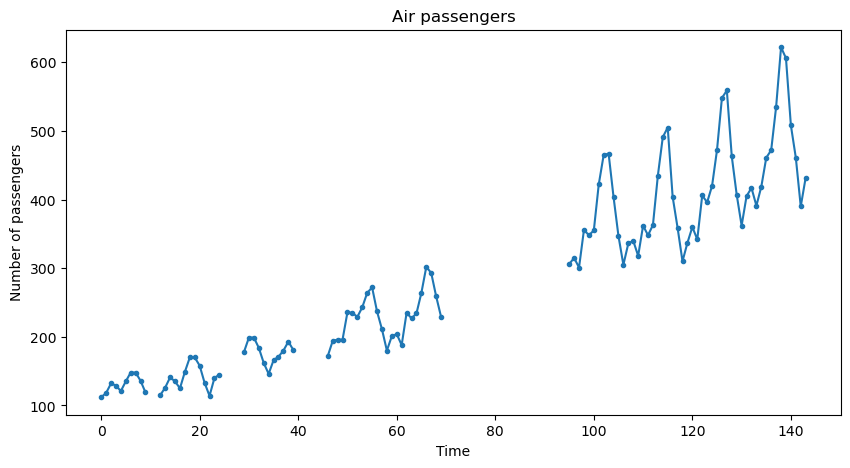

In [613]:
ax = df.plot(marker=".", figsize=[10, 5], legend=None)
ax.set_title("Air passengers")
ax.set_ylabel("Number of passengers")
ax.set_xlabel("Time")
plt.show()

Let's impute missing data by carrying the last observed value in any interval to the next valid value:

In [614]:
df_imputed = df.ffill()

df_imputed.isnull().sum()

ds    0
y     0
dtype: int64

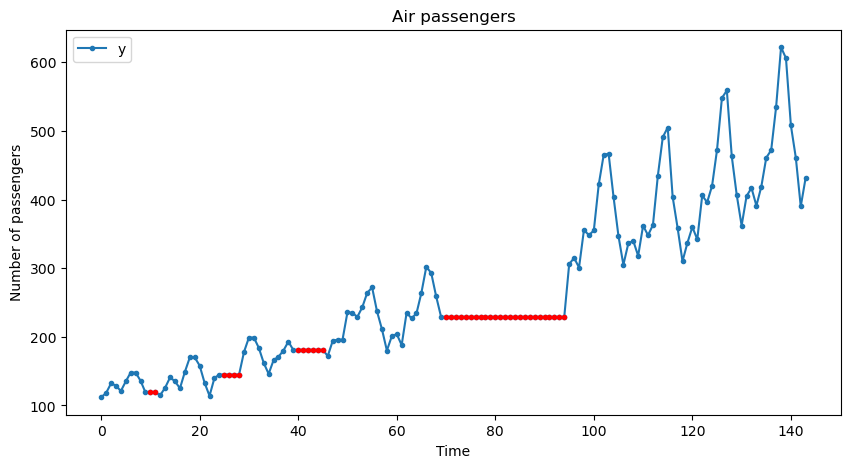

In [615]:
ax = df_imputed.plot(linestyle='-', marker='.', figsize=(10, 5))
df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')
ax.set_title('Air passengers')
ax.set_ylabel('Number of passengers')
ax.set_xlabel('Time')
plt.show()

Alternatively, we can impute missing data using backward fill:

In [616]:
df_imputed = df.bfill()

df_imputed.isnull().sum()

ds    0
y     0
dtype: int64

### Carrying out interpolation

We can impute missing data in time series by using interpolation between two non-missing data points. Interpolation is the estimation of one or more values in a range by means of a function. In linear interpolation, we fit a linear function between the last observed value and the next valid point. In spline interpolation, we fit a low-degree polynomial between the last and next observed values. The idea of using interpolation is to obtain better estimates of the missing data


In [617]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../source/ch01-missing-data-imputation/air_passengers.csv', parse_dates=['ds'], index_col=['ds'])

df.head()

,y
ds,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


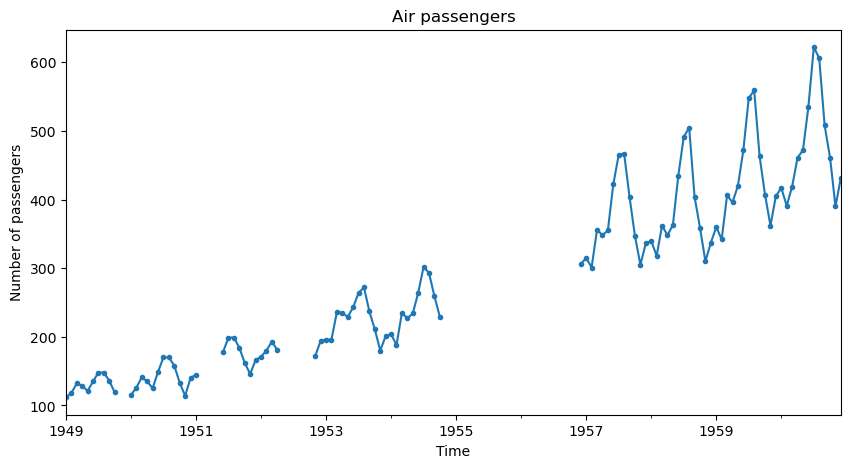

In [618]:
ax = df.plot(marker=".", figsize=[10, 5], legend=None)
ax.set_title("Air passengers")
ax.set_ylabel("Number of passengers")
ax.set_xlabel("Time")
plt.show()

Let's impute the missing data by linear interpolation:

In [619]:
df_imputed = df.interpolate(method='linear')

**IMPORTANT**: If the time intervals between rows are not uniform then the method should be set to time to achieve a linear fit.

In [620]:
df_imputed.isnull().sum()

y    0
dtype: int64

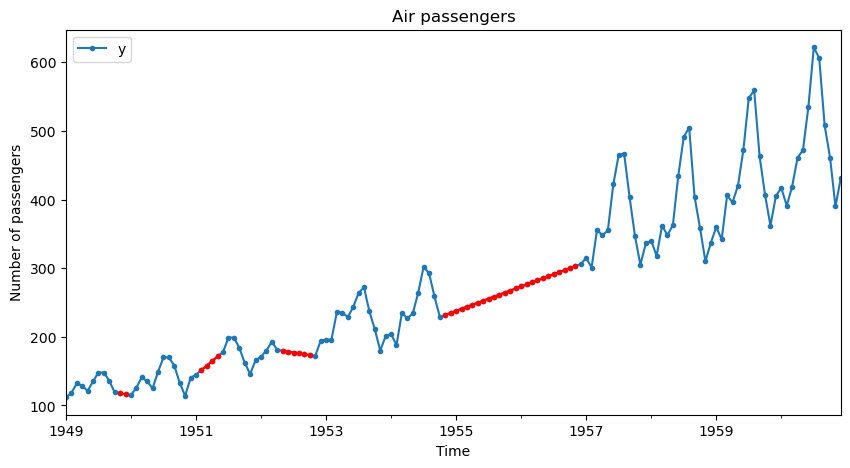

In [621]:
ax = df_imputed.plot(linestyle='-', marker='.', figsize=(10, 5))
df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')
ax.set_title('Air passengers')
ax.set_ylabel('Number of passengers')
ax.set_xlabel('Time')
plt.show()

## Performing multivariate imputation by chained equations

Multivariate imputation methods, as opposed to univariate imputation, use multiple variables to estimate the missing values. Multivariate Imputation by Chained Equations (MICE) models each variable with missing values as a function of the remaining variables in the dataset. The output of that function is used to replace missing data

In [622]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (
    IterativeImputer,
    SimpleImputer
)

# Let's load some numerical variables from the dataset described in the Technical requirements section
variables = ["A2", "A3", "A8", "A11", "A14", "A15", "target"]
data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv', usecols=variables)

data.head()

,A2,A3,A8,A11,A14,A15,target
0,30.83,0.000,1.25,1,202.0,0,1
1,58.67,4.460,3.04,6,43.0,560,1
2,24.50,NaN,1.50,0,280.0,824,1
3,27.83,1.540,3.75,5,100.0,3,1
4,20.17,5.625,1.71,0,120.0,0,1


In [623]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

Let's create a MICE imputer using Bayes regression, specifying the number of iteration cycles and setting random_state for reproducibility

In [625]:
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0,
).set_output(transform='pandas')

imputer.fit(X_train)

IterativeImputer(estimator=BayesianRidge(), random_state=0)

**NOTE**: We can use any regression model to estimate the missing data with IterativeImputer().

In [626]:
X_train_t = imputer.transform(X_train)
X_test_t = imputer.transform(X_test)

In [627]:
X_train_t.isnull().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64

## Estimating missing data with nearest neighbors

Imputation with K-Nearest Neighbors (KNN) involves estimating missing values in a dataset by considering the values of their nearest neighbors, where similarity between data points is determined based on a distance metric, such as the Euclidean distance. It assigns the missing value the average of the nearest neighbors' values, weighted by their distance

In [628]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Let's load some numerical variables from the dataset described in the Technical requirements section
variables = ["A2", "A3", "A8", "A11", "A14", "A15", "target"]
data = pd.read_csv('../source/ch01-missing-data-imputation/credit_approval_uci.csv', usecols=variables)

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=.3, random_state=0)

In [629]:
imputer = KNNImputer(n_neighbors=5, weights="distance",).set_output(transform='pandas')

imputer.fit(X_train)

KNNImputer(weights='distance')

In [630]:
X_train_t = imputer.transform(X_train)
X_test_t = imputer.transform(X_test)

X_test_t.isnull().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64